# Deep Learning Assignment 3 - Stock price predictions with RNNs

In [1]:

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import optuna


warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


## Preprocessing and Visualization

In [2]:
# loading and data cleaning
train_df = pd.read_csv("./data/Google_Stock_Price_Train.csv")
test_df = pd.read_csv("./data/Google_Stock_Price_Test.csv")
train_df['Date']=pd.to_datetime(train_df['Date'])
train_df['Volume'] = train_df['Volume'].str.replace(',', '').astype(float)
train_df['Close'] = train_df['Close'].str.replace(',', '').astype(float)

test_df['Date']=pd.to_datetime(test_df['Date'])
test_df['Volume'] = test_df['Volume'].str.replace(',', '').astype(float)

split_ratio = 0.8
split_point = int(len(train_df) * split_ratio)
val_df = train_df[split_point:] 
train_df = train_df[:split_point]  

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 1006
Validation set size: 252
Test set size: 20


In [3]:
train_df.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,7380500.0
1,2012-01-04,331.27,333.87,329.08,666.45,5749400.0
2,2012-01-05,329.83,330.75,326.89,657.21,6590300.0
3,2012-01-06,328.34,328.77,323.68,648.24,5405900.0
4,2012-01-09,322.04,322.29,309.46,620.76,11688800.0


In [4]:
# visualizing trends
def visualise_data(df, title):
    temp = df.copy()
    temp['Date'] = pd.to_datetime(temp['Date'])
    temp.set_index('Date', inplace=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    fig.suptitle(title, fontsize=16, y=1.02)
    
    ax.plot(temp.index, temp['Open'], label='Open', color='green')
    ax.set_ylabel('Open Price', size=12)
    ax.set_xlabel('Date', size=15)
    ax.legend()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


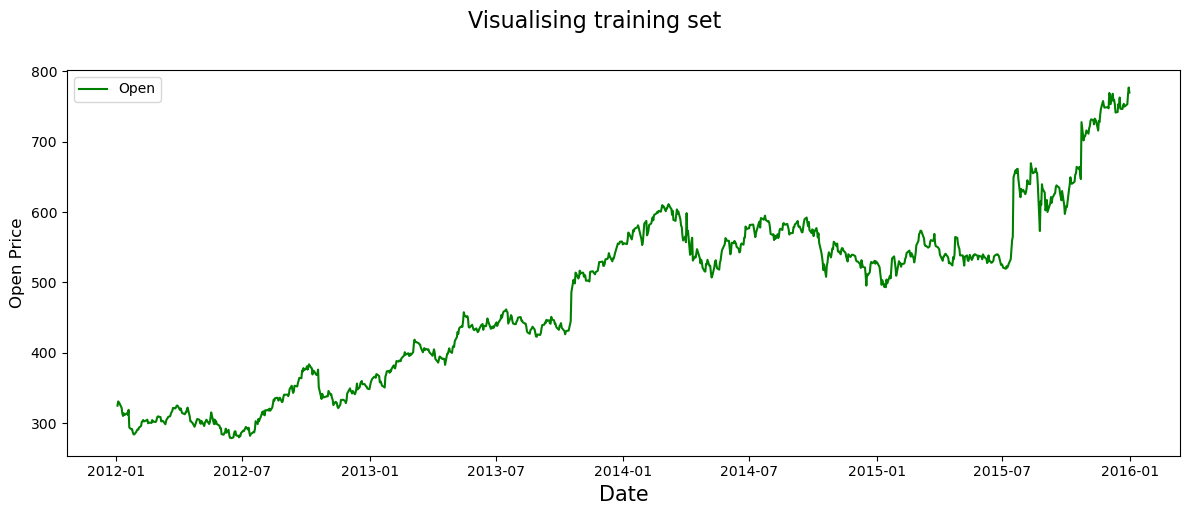

In [5]:
visualise_data(train_df, title = 'Visualising training set')

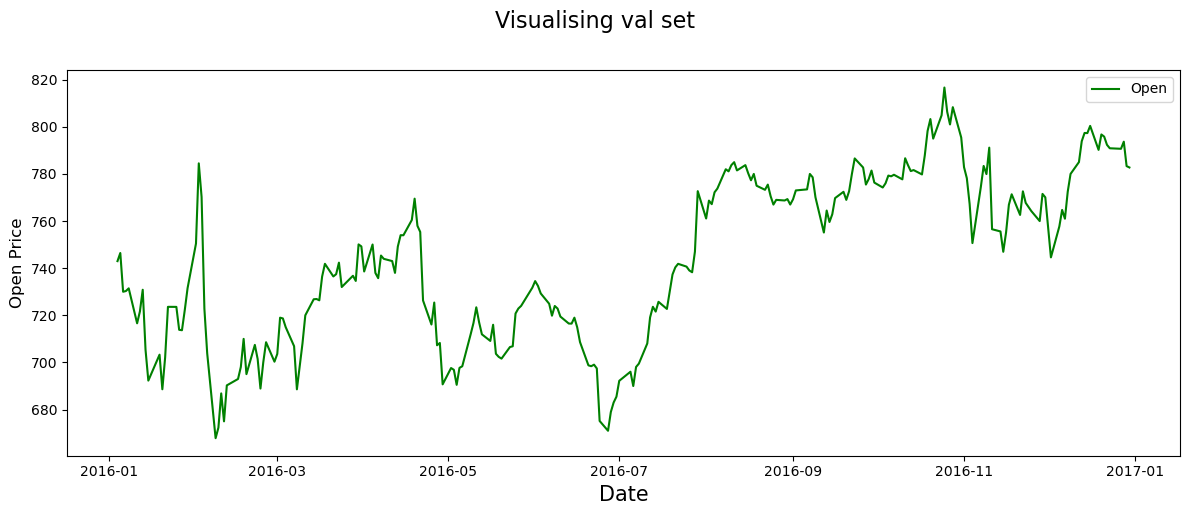

In [6]:
visualise_data(val_df, title = 'Visualising val set')

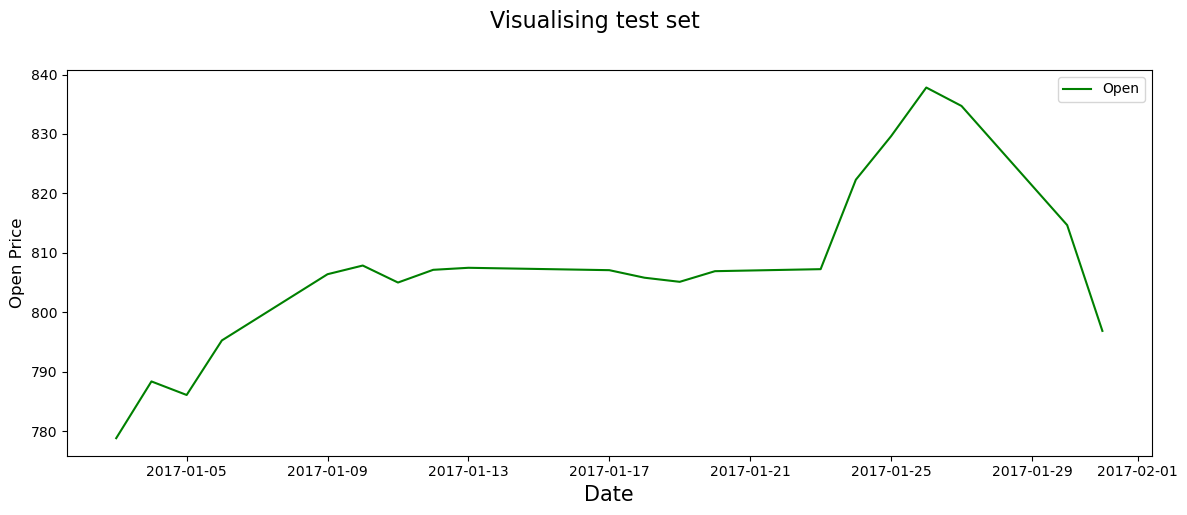

In [7]:
visualise_data(test_df, title = 'Visualising test set')

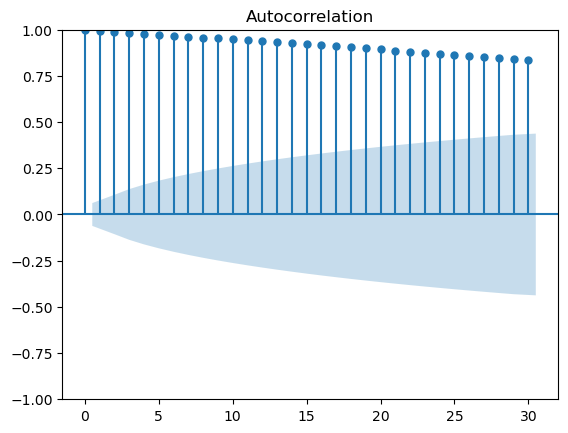

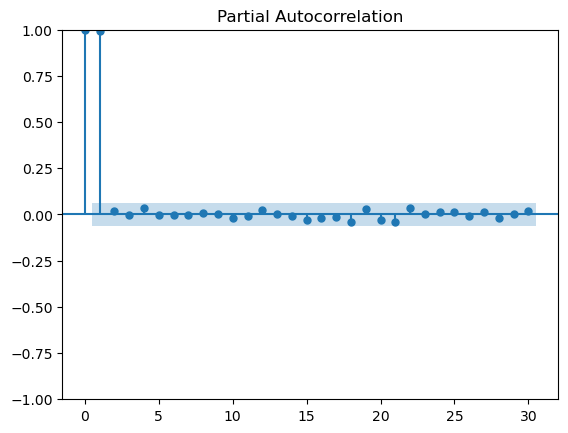

In [8]:
# ACF & PACF plots
plot_acf(train_df['Open'], lags=30);
plot_pacf(train_df['Open'], lags=30);

In [9]:

def prepare_sequences(data,N = 10):
    X = []
    y = []
    l = len(data)
    for i in range(N, l):
        X.append(data[i-N:i,0])
        y.append(data[i,0])
    X, y = np.array(X), np.array(y)
    return np.reshape(X, (X.shape[0], X.shape[1],1)), y



In [10]:

def plot_predictions(yhat, ytrue, scaler, target_column_index):
    ytrue_reshaped = ytrue.reshape(-1, 1)
    yhat_reshaped = yhat.reshape(-1, 1)
    dummy_array = np.zeros((len(ytrue), scaler.n_features_in_))
    dummy_array[:, target_column_index] = ytrue_reshaped[:, 0]
    ytrue_original = scaler.inverse_transform(dummy_array)[:, target_column_index]
    
    dummy_array[:, target_column_index] = yhat_reshaped[:, 0]
    yhat_original = scaler.inverse_transform(dummy_array)[:, target_column_index]
    
    plt.figure(figsize=(10, 6))
    plt.plot(ytrue_original, label='True Values', color='blue')
    plt.plot(yhat_original, label='Predictions', color='red', alpha=0.7)
    plt.legend()
    plt.grid()
    plt.title("True vs Predicted Values (Original Scale)")
    plt.show()



def evaluate_rmse(X, y, model):
    loss = model.evaluate(X, y, verbose=0)
    rmse = np.sqrt(loss)
    return rmse



In [11]:
def plot_learning_curves(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training Loss', )
    plt.plot(epochs, val_loss, label='Validation Loss', )
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

## RNN Baseline

In [12]:
timesteps = 15
n_features = 1

train = train_df[['Open']]
test = test_df[['Open']]
val = val_df[['Open']]
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(train)
train_scaled = scaler.transform(train)  
val_scaled = scaler.transform(val)      
test_scaled = scaler.transform(test)   
X_train, y_train = prepare_sequences(train_scaled, N = timesteps)
X_val, y_val = prepare_sequences(val_scaled, N = timesteps)

In [13]:

v_rnn = Sequential([
    SimpleRNN(1, activation='tanh', input_shape=(timesteps, n_features)),
    Dense(1)  
])
v_rnn.compile(optimizer='adam', loss='mse')
history = v_rnn.fit(X_train, y_train, epochs=20, batch_size=16, validation_data = (X_val,y_val))

Epoch 1/20
62/62 [==============================] - 6s 91ms/step - loss: 0.2352 - val_loss: 0.0124
Epoch 2/20
62/62 [==============================] - 5s 85ms/step - loss: 0.1213 - val_loss: 0.0039
Epoch 3/20
62/62 [==============================] - 5s 83ms/step - loss: 0.0676 - val_loss: 0.0109
Epoch 4/20
62/62 [==============================] - 5s 78ms/step - loss: 0.0389 - val_loss: 0.0241
Epoch 5/20
62/62 [==============================] - 6s 93ms/step - loss: 0.0241 - val_loss: 0.0379
Epoch 6/20
62/62 [==============================] - 5s 86ms/step - loss: 0.0165 - val_loss: 0.0498
Epoch 7/20
62/62 [==============================] - 6s 94ms/step - loss: 0.0126 - val_loss: 0.0598
Epoch 8/20
62/62 [==============================] - 6s 91ms/step - loss: 0.0106 - val_loss: 0.0662
Epoch 9/20
62/62 [==============================] - 6s 89ms/step - loss: 0.0095 - val_loss: 0.0704
Epoch 10/20
62/62 [==============================] - 6s 95ms/step - loss: 0.0088 - val_loss: 0.0739
Epoch 11/

8/8 [==============================] - 0s 18ms/step
RMSE: 0.2642682007906714


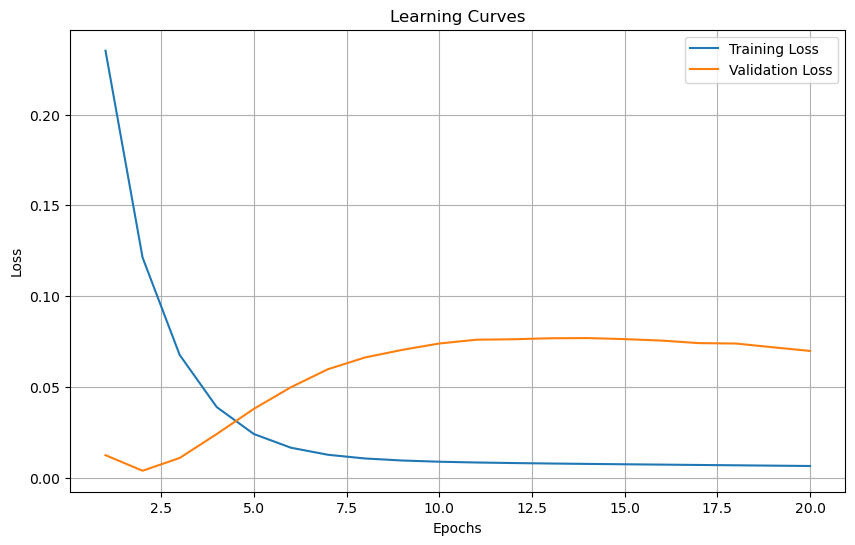

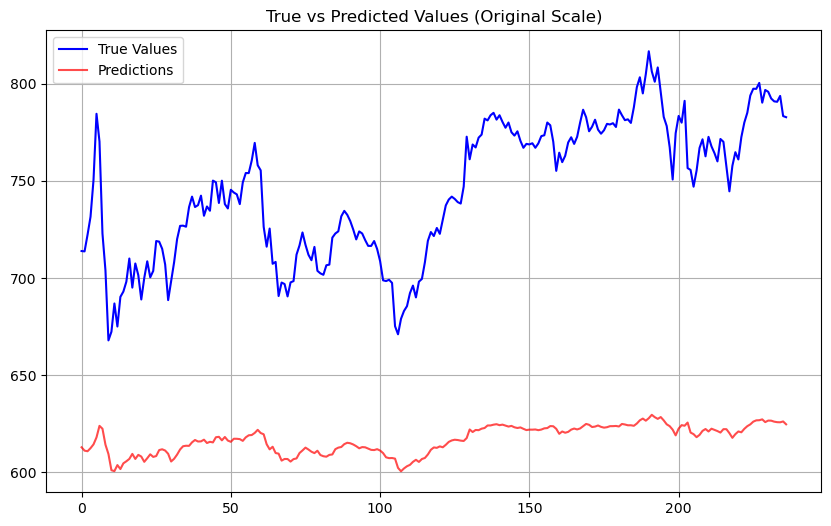

In [14]:

predictions = v_rnn.predict(X_val)
vrnn_rmse = evaluate_rmse(model=v_rnn, X=X_val, y = y_val)
print(f"RMSE: {vrnn_rmse}")
plot_learning_curves(history)


plot_predictions(yhat = predictions, ytrue=y_val, scaler = scaler, target_column_index=0 )

## Vanilla RNN Optimization 

In [15]:

def create_model_RNN(layers, optimizer, sequence, units):

    model = Sequential()
    
    for i in range(layers):
        if i == 0:
            model.add(SimpleRNN(units, activation='tanh', return_sequences=(i < layers - 1), input_shape=(sequence, 1)))
        else:
            model.add(SimpleRNN(units, activation='tanh', return_sequences=(i < layers - 1)))
    model.add(Dense(1)) 
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

def objective_optimize_vrnn(trial):
   


    layers = trial.suggest_int("layers", 1, 2,3)  
    units = trial.suggest_int("units", 10, 50, step=10)  
    optimizer = trial.suggest_categorical("optimizer", ["adam"])  
    sequence = trial.suggest_int("sequence", 1, 5)  

    X_train, y_train = prepare_sequences(train_scaled, N=sequence)
    X_val, y_val = prepare_sequences(val_scaled, N=sequence)

    model = create_model_RNN(layers=layers, optimizer=optimizer, sequence=sequence, units=units)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=16,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=2
    )

    
    val_loss = model.evaluate(X_val, y_val, verbose=0)
    val_rmse = np.sqrt(val_loss)
    
    if val_rmse < objective_optimize_vrnn.best_rmse:
        objective_optimize_vrnn.best_rmse = val_rmse
        objective_optimize_vrnn.best_hyperparams = {
            "layers": layers,
            "units": units,
            "optimizer": optimizer,
            "sequence": sequence
        }
        print(f"New Best Validation RMSE: {objective_optimize_vrnn.best_rmse}")
        print(f"New Best Hyperparameters: {objective_optimize_vrnn.best_hyperparams}")

    return val_rmse





In [16]:



objective_optimize_vrnn.best_rmse = vrnn_rmse
objective_optimize_vrnn.best_hyperparams = None
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective_optimize_vrnn, n_trials=10)


print("Best Validation RMSE:", objective_optimize_vrnn.best_rmse )
print("Best Hyperparameters:", objective_optimize_vrnn.best_hyperparams)

[I 2024-12-01 20:25:23,322] A new study created in memory with name: no-name-16aecb20-537c-4ec9-a828-b592c2d7d5c1


Epoch 1/10
63/63 - 3s - loss: 0.0313 - val_loss: 9.3442e-04 - 3s/epoch - 42ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0138 - val_loss: 0.0053 - 1s/epoch - 23ms/step
Epoch 3/10
63/63 - 2s - loss: 0.0096 - val_loss: 4.4535e-04 - 2s/epoch - 26ms/step
Epoch 4/10
63/63 - 1s - loss: 0.0051 - val_loss: 0.0024 - 1s/epoch - 23ms/step
Epoch 5/10
63/63 - 2s - loss: 0.0102 - val_loss: 0.0143 - 2s/epoch - 26ms/step
Epoch 6/10
63/63 - 2s - loss: 0.0148 - val_loss: 4.9907e-04 - 2s/epoch - 24ms/step
Epoch 7/10
63/63 - 2s - loss: 0.0157 - val_loss: 0.0091 - 2s/epoch - 25ms/step
Epoch 8/10
63/63 - 2s - loss: 0.0072 - val_loss: 0.0032 - 2s/epoch - 28ms/step


[I 2024-12-01 20:25:37,269] Trial 0 finished with value: 0.021103267983762525 and parameters: {'layers': 1, 'units': 20, 'optimizer': 'adam', 'sequence': 5}. Best is trial 0 with value: 0.021103267983762525.


New Best Validation RMSE: 0.021103267983762525
New Best Hyperparameters: {'layers': 1, 'units': 20, 'optimizer': 'adam', 'sequence': 5}
Epoch 1/10
63/63 - 2s - loss: 0.0068 - val_loss: 0.0016 - 2s/epoch - 31ms/step
Epoch 2/10
63/63 - 1s - loss: 6.7507e-04 - val_loss: 0.0035 - 962ms/epoch - 15ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0011 - val_loss: 0.0023 - 965ms/epoch - 15ms/step
Epoch 4/10
63/63 - 1s - loss: 9.7946e-04 - val_loss: 0.0016 - 928ms/epoch - 15ms/step
Epoch 5/10
63/63 - 1s - loss: 6.9497e-04 - val_loss: 0.0017 - 926ms/epoch - 15ms/step
Epoch 6/10
63/63 - 1s - loss: 4.9808e-04 - val_loss: 6.4719e-04 - 935ms/epoch - 15ms/step
Epoch 7/10
63/63 - 1s - loss: 4.6814e-04 - val_loss: 0.0013 - 942ms/epoch - 15ms/step
Epoch 8/10
63/63 - 1s - loss: 4.8885e-04 - val_loss: 8.7412e-04 - 958ms/epoch - 15ms/step
Epoch 9/10
63/63 - 1s - loss: 5.0133e-04 - val_loss: 6.3592e-04 - 1s/epoch - 16ms/step
Epoch 10/10
63/63 - 1s - loss: 7.3565e-04 - val_loss: 0.0019 - 1s/epoch - 21ms/step


[I 2024-12-01 20:25:48,468] Trial 1 finished with value: 0.04309645958977129 and parameters: {'layers': 1, 'units': 40, 'optimizer': 'adam', 'sequence': 3}. Best is trial 0 with value: 0.021103267983762525.


Epoch 1/10
63/63 - 2s - loss: 0.0073 - val_loss: 0.0177 - 2s/epoch - 26ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0017 - val_loss: 0.0065 - 872ms/epoch - 14ms/step
Epoch 3/10
63/63 - 1s - loss: 5.9492e-04 - val_loss: 0.0028 - 911ms/epoch - 14ms/step
Epoch 4/10
63/63 - 1s - loss: 3.6876e-04 - val_loss: 0.0019 - 827ms/epoch - 13ms/step
Epoch 5/10
63/63 - 1s - loss: 3.4236e-04 - val_loss: 0.0014 - 734ms/epoch - 12ms/step
Epoch 6/10
63/63 - 1s - loss: 3.4215e-04 - val_loss: 0.0018 - 756ms/epoch - 12ms/step
Epoch 7/10
63/63 - 1s - loss: 3.4262e-04 - val_loss: 0.0017 - 644ms/epoch - 10ms/step
Epoch 8/10
63/63 - 1s - loss: 3.4253e-04 - val_loss: 0.0013 - 648ms/epoch - 10ms/step
Epoch 9/10
63/63 - 1s - loss: 3.3952e-04 - val_loss: 0.0013 - 644ms/epoch - 10ms/step
Epoch 10/10
63/63 - 1s - loss: 3.4155e-04 - val_loss: 0.0016 - 1s/epoch - 17ms/step


[I 2024-12-01 20:25:57,589] Trial 2 finished with value: 0.04016079511181618 and parameters: {'layers': 1, 'units': 10, 'optimizer': 'adam', 'sequence': 1}. Best is trial 0 with value: 0.021103267983762525.


Epoch 1/10
63/63 - 2s - loss: 0.0108 - val_loss: 0.0177 - 2s/epoch - 35ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0013 - val_loss: 0.0101 - 1s/epoch - 22ms/step
Epoch 3/10
63/63 - 2s - loss: 8.6064e-04 - val_loss: 0.0061 - 2s/epoch - 25ms/step
Epoch 4/10
63/63 - 2s - loss: 6.3402e-04 - val_loss: 0.0036 - 2s/epoch - 26ms/step
Epoch 5/10
63/63 - 2s - loss: 5.2674e-04 - val_loss: 0.0027 - 2s/epoch - 24ms/step
Epoch 6/10
63/63 - 2s - loss: 4.9699e-04 - val_loss: 0.0016 - 2s/epoch - 26ms/step
Epoch 7/10
63/63 - 2s - loss: 4.8487e-04 - val_loss: 0.0015 - 2s/epoch - 24ms/step
Epoch 8/10
63/63 - 1s - loss: 4.7934e-04 - val_loss: 0.0017 - 1s/epoch - 22ms/step
Epoch 9/10
63/63 - 2s - loss: 4.7394e-04 - val_loss: 0.0012 - 2s/epoch - 25ms/step
Epoch 10/10
63/63 - 1s - loss: 4.7420e-04 - val_loss: 0.0014 - 1s/epoch - 23ms/step


[I 2024-12-01 20:26:13,736] Trial 3 finished with value: 0.03780800479629627 and parameters: {'layers': 1, 'units': 10, 'optimizer': 'adam', 'sequence': 5}. Best is trial 0 with value: 0.021103267983762525.


Epoch 1/10
63/63 - 2s - loss: 0.0512 - val_loss: 0.0148 - 2s/epoch - 30ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0031 - val_loss: 0.0054 - 1s/epoch - 18ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0010 - val_loss: 0.0013 - 1s/epoch - 21ms/step
Epoch 4/10
63/63 - 2s - loss: 0.0013 - val_loss: 0.0045 - 2s/epoch - 25ms/step
Epoch 5/10
63/63 - 1s - loss: 8.5774e-04 - val_loss: 0.0032 - 1s/epoch - 19ms/step
Epoch 6/10
63/63 - 1s - loss: 0.0013 - val_loss: 0.0085 - 1s/epoch - 22ms/step
Epoch 7/10
63/63 - 1s - loss: 0.0010 - val_loss: 0.0015 - 1s/epoch - 18ms/step
Epoch 8/10
63/63 - 1s - loss: 7.4188e-04 - val_loss: 0.0013 - 1s/epoch - 20ms/step


[I 2024-12-01 20:26:24,869] Trial 4 finished with value: 0.03545892906920066 and parameters: {'layers': 1, 'units': 40, 'optimizer': 'adam', 'sequence': 4}. Best is trial 0 with value: 0.021103267983762525.


Epoch 1/10
63/63 - 2s - loss: 0.0666 - val_loss: 0.1033 - 2s/epoch - 39ms/step
Epoch 2/10
63/63 - 2s - loss: 0.0056 - val_loss: 0.0541 - 2s/epoch - 27ms/step
Epoch 3/10
63/63 - 2s - loss: 0.0040 - val_loss: 0.0426 - 2s/epoch - 28ms/step
Epoch 4/10
63/63 - 1s - loss: 0.0031 - val_loss: 0.0324 - 1s/epoch - 23ms/step
Epoch 5/10
63/63 - 1s - loss: 0.0025 - val_loss: 0.0252 - 1s/epoch - 23ms/step
Epoch 6/10
63/63 - 1s - loss: 0.0020 - val_loss: 0.0178 - 1s/epoch - 23ms/step
Epoch 7/10
63/63 - 2s - loss: 0.0017 - val_loss: 0.0163 - 2s/epoch - 24ms/step
Epoch 8/10
63/63 - 2s - loss: 0.0014 - val_loss: 0.0109 - 2s/epoch - 24ms/step
Epoch 9/10
63/63 - 1s - loss: 0.0013 - val_loss: 0.0129 - 1s/epoch - 22ms/step
Epoch 10/10
63/63 - 1s - loss: 0.0011 - val_loss: 0.0083 - 1s/epoch - 23ms/step


[I 2024-12-01 20:26:41,282] Trial 5 finished with value: 0.09086569810810514 and parameters: {'layers': 1, 'units': 10, 'optimizer': 'adam', 'sequence': 5}. Best is trial 0 with value: 0.021103267983762525.


Epoch 1/10
63/63 - 3s - loss: 0.0258 - val_loss: 0.0011 - 3s/epoch - 46ms/step
Epoch 2/10
63/63 - 1s - loss: 9.3225e-04 - val_loss: 0.0026 - 912ms/epoch - 14ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0133 - val_loss: 0.0016 - 979ms/epoch - 16ms/step
Epoch 4/10
63/63 - 1s - loss: 8.4270e-04 - val_loss: 0.0015 - 892ms/epoch - 14ms/step
Epoch 5/10
63/63 - 1s - loss: 0.0059 - val_loss: 0.0068 - 922ms/epoch - 15ms/step
Epoch 6/10
63/63 - 1s - loss: 0.0044 - val_loss: 0.0010 - 856ms/epoch - 14ms/step
Epoch 7/10
63/63 - 1s - loss: 5.6735e-04 - val_loss: 0.0015 - 951ms/epoch - 15ms/step
Epoch 8/10
63/63 - 1s - loss: 0.0024 - val_loss: 0.0026 - 837ms/epoch - 13ms/step
Epoch 9/10
63/63 - 1s - loss: 9.2479e-04 - val_loss: 0.0020 - 917ms/epoch - 15ms/step
Epoch 10/10
63/63 - 1s - loss: 5.2625e-04 - val_loss: 0.0018 - 789ms/epoch - 13ms/step


[I 2024-12-01 20:26:52,535] Trial 6 finished with value: 0.04218854295801261 and parameters: {'layers': 1, 'units': 50, 'optimizer': 'adam', 'sequence': 2}. Best is trial 0 with value: 0.021103267983762525.


Epoch 1/10
63/63 - 1s - loss: 0.1768 - val_loss: 0.4298 - 1s/epoch - 21ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0472 - val_loss: 0.1684 - 656ms/epoch - 10ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0280 - val_loss: 0.1111 - 636ms/epoch - 10ms/step
Epoch 4/10
63/63 - 1s - loss: 0.0209 - val_loss: 0.0843 - 647ms/epoch - 10ms/step
Epoch 5/10
63/63 - 1s - loss: 0.0147 - val_loss: 0.0566 - 713ms/epoch - 11ms/step
Epoch 6/10
63/63 - 1s - loss: 0.0097 - val_loss: 0.0393 - 701ms/epoch - 11ms/step
Epoch 7/10
63/63 - 1s - loss: 0.0059 - val_loss: 0.0258 - 655ms/epoch - 10ms/step
Epoch 8/10
63/63 - 1s - loss: 0.0033 - val_loss: 0.0151 - 811ms/epoch - 13ms/step
Epoch 9/10
63/63 - 1s - loss: 0.0018 - val_loss: 0.0093 - 706ms/epoch - 11ms/step
Epoch 10/10
63/63 - 1s - loss: 9.5533e-04 - val_loss: 0.0056 - 750ms/epoch - 12ms/step


[I 2024-12-01 20:27:00,373] Trial 7 finished with value: 0.07495689991488166 and parameters: {'layers': 1, 'units': 10, 'optimizer': 'adam', 'sequence': 1}. Best is trial 0 with value: 0.021103267983762525.


Epoch 1/10
63/63 - 2s - loss: 0.0956 - val_loss: 0.0668 - 2s/epoch - 37ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0049 - val_loss: 0.0257 - 1s/epoch - 24ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0185 - val_loss: 0.0048 - 1s/epoch - 18ms/step
Epoch 4/10
63/63 - 1s - loss: 0.0067 - val_loss: 0.0116 - 1s/epoch - 18ms/step
Epoch 5/10
63/63 - 1s - loss: 0.0178 - val_loss: 0.0170 - 1s/epoch - 19ms/step
Epoch 6/10
63/63 - 1s - loss: 0.0037 - val_loss: 0.0083 - 1s/epoch - 17ms/step
Epoch 7/10
63/63 - 1s - loss: 0.0016 - val_loss: 0.0067 - 1s/epoch - 17ms/step
Epoch 8/10
63/63 - 1s - loss: 0.0012 - val_loss: 0.0086 - 1s/epoch - 18ms/step


[I 2024-12-01 20:27:11,241] Trial 8 finished with value: 0.06952483343134785 and parameters: {'layers': 1, 'units': 20, 'optimizer': 'adam', 'sequence': 3}. Best is trial 0 with value: 0.021103267983762525.


Epoch 1/10
63/63 - 2s - loss: 0.0173 - val_loss: 0.0069 - 2s/epoch - 30ms/step
Epoch 2/10
63/63 - 1s - loss: 7.5726e-04 - val_loss: 0.0054 - 905ms/epoch - 14ms/step
Epoch 3/10
63/63 - 1s - loss: 6.0118e-04 - val_loss: 0.0029 - 767ms/epoch - 12ms/step
Epoch 4/10
63/63 - 1s - loss: 5.9491e-04 - val_loss: 0.0035 - 771ms/epoch - 12ms/step
Epoch 5/10
63/63 - 1s - loss: 5.5781e-04 - val_loss: 0.0035 - 786ms/epoch - 12ms/step
Epoch 6/10
63/63 - 1s - loss: 5.3560e-04 - val_loss: 0.0035 - 893ms/epoch - 14ms/step
Epoch 7/10
63/63 - 1s - loss: 5.3524e-04 - val_loss: 0.0017 - 901ms/epoch - 14ms/step
Epoch 8/10
63/63 - 1s - loss: 5.3314e-04 - val_loss: 0.0044 - 762ms/epoch - 12ms/step
Epoch 9/10
63/63 - 1s - loss: 5.1115e-04 - val_loss: 0.0029 - 808ms/epoch - 13ms/step
Epoch 10/10
63/63 - 1s - loss: 4.8090e-04 - val_loss: 0.0029 - 873ms/epoch - 14ms/step


[I 2024-12-01 20:27:20,941] Trial 9 finished with value: 0.05370689940445063 and parameters: {'layers': 1, 'units': 30, 'optimizer': 'adam', 'sequence': 2}. Best is trial 0 with value: 0.021103267983762525.


Best Validation RMSE: 0.021103267983762525
Best Hyperparameters: {'layers': 1, 'units': 20, 'optimizer': 'adam', 'sequence': 5}


## RNN retraining with optimized model

1258 20
Epoch 1/20
79/79 - 3s - loss: 0.0155 - val_loss: 0.0054 - 3s/epoch - 44ms/step
Epoch 2/20
79/79 - 2s - loss: 0.0042 - val_loss: 0.0089 - 2s/epoch - 21ms/step
Epoch 3/20
79/79 - 2s - loss: 0.0022 - val_loss: 0.0042 - 2s/epoch - 20ms/step
Epoch 4/20
79/79 - 2s - loss: 0.0012 - val_loss: 4.9896e-04 - 2s/epoch - 25ms/step
Epoch 5/20
79/79 - 2s - loss: 0.0017 - val_loss: 5.9325e-04 - 2s/epoch - 21ms/step
Epoch 6/20
79/79 - 2s - loss: 0.0014 - val_loss: 0.0012 - 2s/epoch - 21ms/step
Epoch 7/20
79/79 - 2s - loss: 0.0014 - val_loss: 9.1847e-04 - 2s/epoch - 21ms/step
Epoch 8/20
79/79 - 2s - loss: 0.0023 - val_loss: 6.0831e-04 - 2s/epoch - 20ms/step
Epoch 9/20
79/79 - 2s - loss: 9.4064e-04 - val_loss: 0.0028 - 2s/epoch - 22ms/step
Test Loss: 0.00049895781558007
RMSE  0.022337363666737175
1/1 [==============================] - 0s 112ms/step


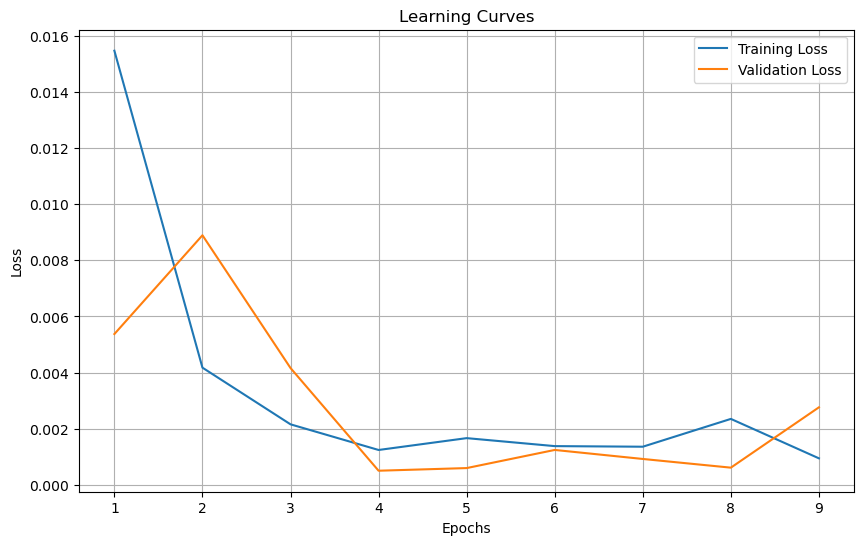

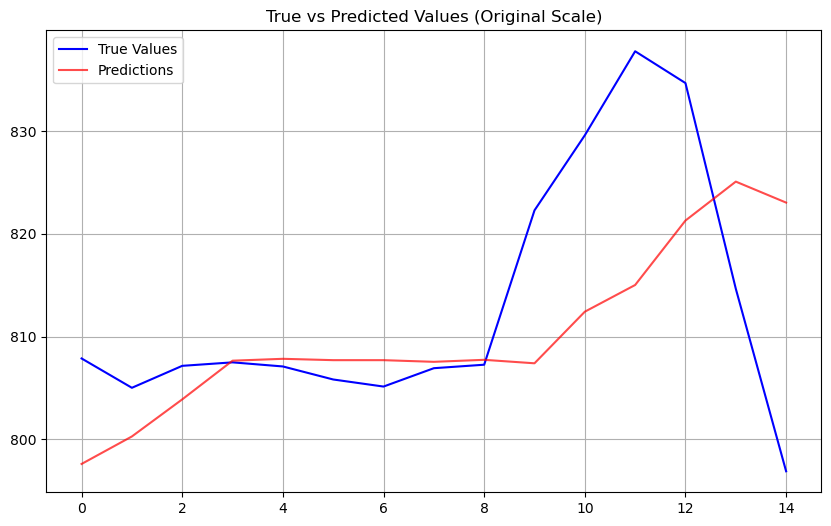

In [17]:



full_train = pd.concat([train_df, val_df], axis=0)
full_train.reset_index(drop=True, inplace=True)
train_open = full_train[['Open']]
test_open = test_df[['Open']]

print(len(train_open), len(test_open))


scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(train_open)
train_scaled_full = scaler.transform(train_open)  
test_scaled_full = scaler.transform(test_open)


X_train_full, y_train_full = prepare_sequences(data = train_scaled_full, N =objective_optimize_vrnn.best_hyperparams['sequence'] )
X_test_full, y_test_full = prepare_sequences(data = test_scaled_full,N =objective_optimize_vrnn.best_hyperparams['sequence'] )


model_retrained_vrnn = create_model_RNN(layers=objective_optimize_vrnn.best_hyperparams['layers'],
                          optimizer=objective_optimize_vrnn.best_hyperparams['optimizer'], 
                          sequence=objective_optimize_vrnn.best_hyperparams['sequence'], 
                          units=objective_optimize_vrnn.best_hyperparams['units'])



early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_retrained_vrnn.fit(
        X_train_full, y_train_full,
        epochs=20,
        batch_size=16,
        validation_data=(X_test_full, y_test_full),
        callbacks=[early_stopping],
        verbose=2
    )

loss_vnn = model_retrained_vrnn.evaluate(X_test_full, y_test_full, verbose = 0)
print(f"Test Loss: {loss_vnn}")
print(f"RMSE  {np.sqrt(loss_vnn)}")
predictions = model_retrained_vrnn.predict(X_test_full)


plot_learning_curves(history)


plot_predictions(yhat = predictions, ytrue=y_test_full, scaler = scaler, target_column_index=0 )

## GRU Baseline

In [18]:
train = train_df[['Open']]
test = test_df[['Open']]
val = val_df[['Open']]
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(train)
N = 15
train_scaled = scaler.transform(train)  
val_scaled = scaler.transform(val)       
X_train, y_train = prepare_sequences(train_scaled, N = N)
X_val, y_val = prepare_sequences(val_scaled, N = N)

Epoch 1/20
62/62 [==============================] - 2s 17ms/step - loss: 0.1335 - val_loss: 0.1849
Epoch 2/20
62/62 [==============================] - 1s 11ms/step - loss: 0.0217 - val_loss: 0.0685
Epoch 3/20
62/62 [==============================] - 1s 14ms/step - loss: 0.0126 - val_loss: 0.0343
Epoch 4/20
62/62 [==============================] - 1s 11ms/step - loss: 0.0062 - val_loss: 0.0160
Epoch 5/20
62/62 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.0044
Epoch 6/20
62/62 [==============================] - 1s 11ms/step - loss: 8.8143e-04 - val_loss: 0.0020
Epoch 7/20
62/62 [==============================] - 1s 18ms/step - loss: 5.4538e-04 - val_loss: 0.0013
Epoch 8/20
62/62 [==============================] - 1s 12ms/step - loss: 4.9910e-04 - val_loss: 0.0010
Epoch 9/20
62/62 [==============================] - 1s 13ms/step - loss: 4.8157e-04 - val_loss: 0.0010
Epoch 10/20
62/62 [==============================] - 1s 11ms/step - loss: 4.7274e-04 - val_lo

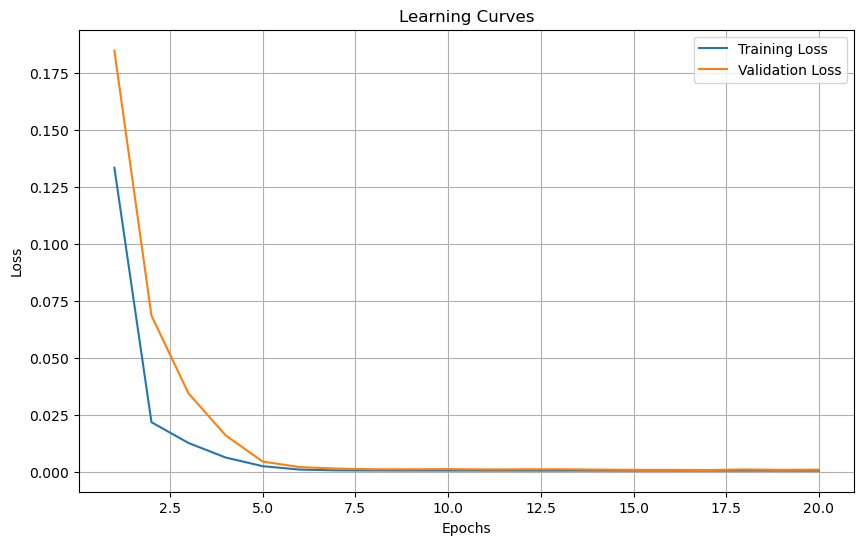

RMSE: 0.02946570546400877


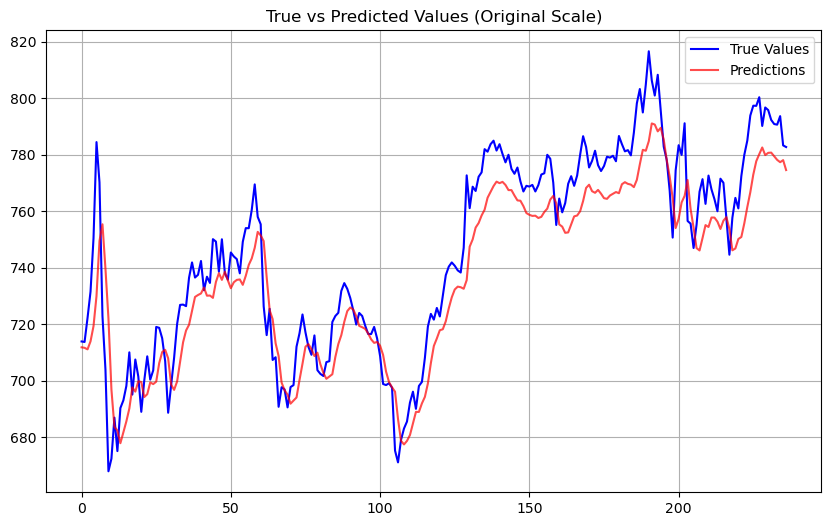

In [19]:

gru = Sequential([
    GRU(units=10, activation='tanh', input_shape=(15, n_features)),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
history = gru.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val))


loss_gru = gru.evaluate(X_val, y_val)
print(f"Val Loss: {loss_gru}")
pred_gru = gru.predict(X_val)


plot_learning_curves(history)
gru_rmse = evaluate_rmse(model=gru, X=X_val, y = y_val)
print(f"RMSE: {gru_rmse}")
plot_predictions(yhat = pred_gru, ytrue=y_val, scaler = scaler, target_column_index=0 )

## GRU Optimization

In [20]:


def create_model_GRU(layers, optimizer, sequence, units):
    model = Sequential()
    
    for i in range(layers):
        if i == 0:
            model.add(GRU(units, activation='tanh', 
                          return_sequences=(i < layers - 1), 
                          input_shape=(sequence, 1)))
        else:
            model.add(GRU(units, activation='tanh', 
                          return_sequences=(i < layers - 1)))
    
    model.add(Dense(1))  
    model.compile(optimizer=optimizer, loss='mse')
    
    return model


def objective_optimize_gru(trial):
   

    
    layers = trial.suggest_int("layers", 1, 2,3)  
    units = trial.suggest_int("units", 10, 50, step=10)  
    optimizer = trial.suggest_categorical("optimizer", ["adam"])  
    sequence = trial.suggest_int("sequence", 1, 5)  



    X_train, y_train = prepare_sequences(train_scaled, N=sequence)
    X_val, y_val = prepare_sequences(val_scaled, N=sequence)

   
    model = create_model_GRU(layers=layers, optimizer=optimizer, sequence=sequence, units=units)

  
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

   
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=16,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=2
    )

   
    val_loss = model.evaluate(X_val, y_val, verbose=0)
    val_rmse = np.sqrt(val_loss)
    
    if val_rmse < objective_optimize_gru.best_rmse:
        objective_optimize_gru.best_rmse = val_rmse
        objective_optimize_gru.best_hyperparams = {
            "layers": layers,
            "units": units,
            "optimizer": optimizer,
            "sequence": sequence
        }
        print(f"New Best Validation RMSE: {objective_optimize_gru.best_rmse}")
        print(f"New Best Hyperparameters: {objective_optimize_gru.best_hyperparams}")

    return val_rmse

In [21]:
objective_optimize_gru.best_rmse = gru_rmse
objective_optimize_gru.best_hyperparams = None
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective_optimize_gru, n_trials=10)


print("Best Validation RMSE:", objective_optimize_gru.best_rmse )
print("Best Hyperparameters:", objective_optimize_gru.best_hyperparams)

[I 2024-12-01 20:27:55,661] A new study created in memory with name: no-name-72227534-f404-4fcf-ac27-0eec7076d871


Epoch 1/10
63/63 - 2s - loss: 0.0945 - val_loss: 0.0575 - 2s/epoch - 33ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0136 - val_loss: 0.0232 - 648ms/epoch - 10ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0044 - val_loss: 0.0028 - 784ms/epoch - 12ms/step
Epoch 4/10
63/63 - 1s - loss: 0.0010 - val_loss: 8.8025e-04 - 739ms/epoch - 12ms/step
Epoch 5/10
63/63 - 1s - loss: 5.8495e-04 - val_loss: 0.0019 - 654ms/epoch - 10ms/step
Epoch 6/10
63/63 - 1s - loss: 5.5938e-04 - val_loss: 0.0013 - 621ms/epoch - 10ms/step
Epoch 7/10
63/63 - 1s - loss: 5.5549e-04 - val_loss: 0.0014 - 617ms/epoch - 10ms/step
Epoch 8/10
63/63 - 1s - loss: 5.4374e-04 - val_loss: 0.0016 - 611ms/epoch - 10ms/step
Epoch 9/10
63/63 - 1s - loss: 5.3697e-04 - val_loss: 9.7803e-04 - 616ms/epoch - 10ms/step


[I 2024-12-01 20:28:03,492] Trial 0 finished with value: 0.029669016374759244 and parameters: {'layers': 1, 'units': 20, 'optimizer': 'adam', 'sequence': 5}. Best is trial 0 with value: 0.029669016374759244.


Epoch 1/10
63/63 - 2s - loss: 0.0494 - val_loss: 0.0262 - 2s/epoch - 36ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0042 - val_loss: 0.0021 - 616ms/epoch - 10ms/step
Epoch 3/10
63/63 - 1s - loss: 7.3940e-04 - val_loss: 0.0011 - 902ms/epoch - 14ms/step
Epoch 4/10
63/63 - 1s - loss: 4.7887e-04 - val_loss: 0.0010 - 660ms/epoch - 10ms/step
Epoch 5/10
63/63 - 1s - loss: 4.5668e-04 - val_loss: 0.0012 - 612ms/epoch - 10ms/step
Epoch 6/10
63/63 - 1s - loss: 4.4769e-04 - val_loss: 0.0013 - 598ms/epoch - 9ms/step
Epoch 7/10
63/63 - 1s - loss: 4.4489e-04 - val_loss: 0.0012 - 593ms/epoch - 9ms/step
Epoch 8/10
63/63 - 1s - loss: 4.4428e-04 - val_loss: 7.9972e-04 - 595ms/epoch - 9ms/step
Epoch 9/10
63/63 - 1s - loss: 4.2959e-04 - val_loss: 0.0012 - 607ms/epoch - 10ms/step
Epoch 10/10
63/63 - 1s - loss: 4.3129e-04 - val_loss: 8.7454e-04 - 642ms/epoch - 10ms/step


[I 2024-12-01 20:28:11,906] Trial 1 finished with value: 0.029572595118617 and parameters: {'layers': 1, 'units': 40, 'optimizer': 'adam', 'sequence': 3}. Best is trial 1 with value: 0.029572595118617.


Epoch 1/10
63/63 - 2s - loss: 0.2222 - val_loss: 0.6614 - 2s/epoch - 35ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0890 - val_loss: 0.3403 - 695ms/epoch - 11ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0481 - val_loss: 0.2017 - 671ms/epoch - 11ms/step
Epoch 4/10
63/63 - 1s - loss: 0.0370 - val_loss: 0.1496 - 638ms/epoch - 10ms/step
Epoch 5/10
63/63 - 1s - loss: 0.0309 - val_loss: 0.1169 - 591ms/epoch - 9ms/step
Epoch 6/10
63/63 - 1s - loss: 0.0253 - val_loss: 0.0932 - 597ms/epoch - 9ms/step
Epoch 7/10
63/63 - 1s - loss: 0.0201 - val_loss: 0.0717 - 662ms/epoch - 11ms/step
Epoch 8/10
63/63 - 1s - loss: 0.0151 - val_loss: 0.0501 - 663ms/epoch - 11ms/step
Epoch 9/10
63/63 - 1s - loss: 0.0105 - val_loss: 0.0311 - 601ms/epoch - 10ms/step
Epoch 10/10
63/63 - 1s - loss: 0.0065 - val_loss: 0.0174 - 576ms/epoch - 9ms/step


[I 2024-12-01 20:28:20,060] Trial 2 finished with value: 0.13186796293873096 and parameters: {'layers': 1, 'units': 10, 'optimizer': 'adam', 'sequence': 1}. Best is trial 1 with value: 0.029572595118617.


Epoch 1/10
63/63 - 2s - loss: 0.0150 - val_loss: 0.0166 - 2s/epoch - 35ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0021 - val_loss: 0.0031 - 675ms/epoch - 11ms/step
Epoch 3/10
63/63 - 1s - loss: 5.7110e-04 - val_loss: 9.3088e-04 - 640ms/epoch - 10ms/step
Epoch 4/10
63/63 - 1s - loss: 3.9932e-04 - val_loss: 7.4621e-04 - 659ms/epoch - 10ms/step
Epoch 5/10
63/63 - 1s - loss: 3.9779e-04 - val_loss: 6.3591e-04 - 711ms/epoch - 11ms/step
Epoch 6/10
63/63 - 1s - loss: 3.9616e-04 - val_loss: 6.5237e-04 - 693ms/epoch - 11ms/step
Epoch 7/10
63/63 - 1s - loss: 3.9729e-04 - val_loss: 6.4480e-04 - 657ms/epoch - 10ms/step
Epoch 8/10
63/63 - 1s - loss: 3.9430e-04 - val_loss: 6.2723e-04 - 755ms/epoch - 12ms/step
Epoch 9/10
63/63 - 1s - loss: 3.9415e-04 - val_loss: 8.9467e-04 - 702ms/epoch - 11ms/step
Epoch 10/10
63/63 - 1s - loss: 3.8920e-04 - val_loss: 6.2735e-04 - 655ms/epoch - 10ms/step


[I 2024-12-01 20:28:28,735] Trial 3 finished with value: 0.02504697108681632 and parameters: {'layers': 1, 'units': 10, 'optimizer': 'adam', 'sequence': 5}. Best is trial 3 with value: 0.02504697108681632.


New Best Validation RMSE: 0.02504697108681632
New Best Hyperparameters: {'layers': 1, 'units': 10, 'optimizer': 'adam', 'sequence': 5}
Epoch 1/10
63/63 - 2s - loss: 0.0363 - val_loss: 0.0211 - 2s/epoch - 31ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0021 - val_loss: 7.6491e-04 - 620ms/epoch - 10ms/step
Epoch 3/10
63/63 - 1s - loss: 4.9638e-04 - val_loss: 0.0012 - 635ms/epoch - 10ms/step
Epoch 4/10
63/63 - 1s - loss: 4.6124e-04 - val_loss: 0.0015 - 611ms/epoch - 10ms/step
Epoch 5/10
63/63 - 1s - loss: 4.6339e-04 - val_loss: 0.0014 - 602ms/epoch - 10ms/step
Epoch 6/10
63/63 - 1s - loss: 4.7265e-04 - val_loss: 7.3012e-04 - 607ms/epoch - 10ms/step
Epoch 7/10
63/63 - 1s - loss: 4.6833e-04 - val_loss: 0.0012 - 607ms/epoch - 10ms/step
Epoch 8/10
63/63 - 1s - loss: 4.3385e-04 - val_loss: 7.1232e-04 - 607ms/epoch - 10ms/step
Epoch 9/10
63/63 - 1s - loss: 4.4887e-04 - val_loss: 9.6208e-04 - 604ms/epoch - 10ms/step
Epoch 10/10
63/63 - 1s - loss: 4.2396e-04 - val_loss: 8.4737e-04 - 631ms/epoch - 10ms/

[I 2024-12-01 20:28:36,503] Trial 4 finished with value: 0.029109674641597066 and parameters: {'layers': 1, 'units': 40, 'optimizer': 'adam', 'sequence': 4}. Best is trial 3 with value: 0.02504697108681632.


Epoch 1/10
63/63 - 2s - loss: 0.1899 - val_loss: 0.3876 - 2s/epoch - 35ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0391 - val_loss: 0.1030 - 617ms/epoch - 10ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0211 - val_loss: 0.0444 - 623ms/epoch - 10ms/step
Epoch 4/10
63/63 - 1s - loss: 0.0087 - val_loss: 0.0085 - 733ms/epoch - 12ms/step
Epoch 5/10
63/63 - 1s - loss: 0.0020 - val_loss: 9.9717e-04 - 621ms/epoch - 10ms/step
Epoch 6/10
63/63 - 1s - loss: 7.6743e-04 - val_loss: 0.0015 - 609ms/epoch - 10ms/step
Epoch 7/10
63/63 - 1s - loss: 7.0841e-04 - val_loss: 0.0017 - 680ms/epoch - 11ms/step
Epoch 8/10
63/63 - 1s - loss: 6.8265e-04 - val_loss: 0.0018 - 611ms/epoch - 10ms/step
Epoch 9/10
63/63 - 1s - loss: 6.6473e-04 - val_loss: 0.0011 - 685ms/epoch - 11ms/step
Epoch 10/10
63/63 - 1s - loss: 6.4722e-04 - val_loss: 0.0015 - 609ms/epoch - 10ms/step


[I 2024-12-01 20:28:44,787] Trial 5 finished with value: 0.03157799668453521 and parameters: {'layers': 1, 'units': 10, 'optimizer': 'adam', 'sequence': 5}. Best is trial 3 with value: 0.02504697108681632.


Epoch 1/10
63/63 - 2s - loss: 0.0584 - val_loss: 0.0269 - 2s/epoch - 39ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0061 - val_loss: 0.0039 - 614ms/epoch - 10ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0012 - val_loss: 0.0011 - 610ms/epoch - 10ms/step
Epoch 4/10
63/63 - 1s - loss: 4.5886e-04 - val_loss: 0.0016 - 601ms/epoch - 10ms/step
Epoch 5/10
63/63 - 1s - loss: 4.2404e-04 - val_loss: 0.0015 - 617ms/epoch - 10ms/step
Epoch 6/10
63/63 - 1s - loss: 4.1300e-04 - val_loss: 0.0012 - 614ms/epoch - 10ms/step
Epoch 7/10
63/63 - 1s - loss: 4.0722e-04 - val_loss: 0.0012 - 637ms/epoch - 10ms/step
Epoch 8/10
63/63 - 1s - loss: 3.9687e-04 - val_loss: 9.7712e-04 - 846ms/epoch - 13ms/step
Epoch 9/10
63/63 - 1s - loss: 3.8940e-04 - val_loss: 8.6972e-04 - 718ms/epoch - 11ms/step
Epoch 10/10
63/63 - 1s - loss: 3.8436e-04 - val_loss: 0.0011 - 666ms/epoch - 11ms/step


[I 2024-12-01 20:28:53,508] Trial 6 finished with value: 0.033360227050776695 and parameters: {'layers': 1, 'units': 50, 'optimizer': 'adam', 'sequence': 2}. Best is trial 3 with value: 0.02504697108681632.


Epoch 1/10
63/63 - 3s - loss: 0.1917 - val_loss: 0.5390 - 3s/epoch - 41ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0710 - val_loss: 0.2504 - 694ms/epoch - 11ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0369 - val_loss: 0.1397 - 704ms/epoch - 11ms/step
Epoch 4/10
63/63 - 1s - loss: 0.0285 - val_loss: 0.1023 - 599ms/epoch - 10ms/step
Epoch 5/10
63/63 - 1s - loss: 0.0234 - val_loss: 0.0775 - 638ms/epoch - 10ms/step
Epoch 6/10
63/63 - 1s - loss: 0.0187 - val_loss: 0.0598 - 676ms/epoch - 11ms/step
Epoch 7/10
63/63 - 1s - loss: 0.0145 - val_loss: 0.0447 - 647ms/epoch - 10ms/step
Epoch 8/10
63/63 - 1s - loss: 0.0109 - val_loss: 0.0306 - 630ms/epoch - 10ms/step
Epoch 9/10
63/63 - 1s - loss: 0.0078 - val_loss: 0.0197 - 568ms/epoch - 9ms/step
Epoch 10/10
63/63 - 1s - loss: 0.0053 - val_loss: 0.0124 - 628ms/epoch - 10ms/step


[I 2024-12-01 20:29:02,120] Trial 7 finished with value: 0.11152708528635766 and parameters: {'layers': 1, 'units': 10, 'optimizer': 'adam', 'sequence': 1}. Best is trial 3 with value: 0.02504697108681632.


Epoch 1/10
63/63 - 2s - loss: 0.0848 - val_loss: 0.0582 - 2s/epoch - 31ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0133 - val_loss: 0.0249 - 665ms/epoch - 11ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0051 - val_loss: 0.0062 - 610ms/epoch - 10ms/step
Epoch 4/10
63/63 - 1s - loss: 0.0013 - val_loss: 6.2426e-04 - 642ms/epoch - 10ms/step
Epoch 5/10
63/63 - 1s - loss: 4.7383e-04 - val_loss: 8.8209e-04 - 692ms/epoch - 11ms/step
Epoch 6/10
63/63 - 1s - loss: 4.1958e-04 - val_loss: 0.0012 - 650ms/epoch - 10ms/step
Epoch 7/10
63/63 - 1s - loss: 4.1786e-04 - val_loss: 0.0013 - 660ms/epoch - 10ms/step
Epoch 8/10
63/63 - 1s - loss: 4.1208e-04 - val_loss: 9.9343e-04 - 681ms/epoch - 11ms/step
Epoch 9/10
63/63 - 1s - loss: 4.0216e-04 - val_loss: 0.0011 - 683ms/epoch - 11ms/step


[I 2024-12-01 20:29:09,618] Trial 8 finished with value: 0.024985197786935573 and parameters: {'layers': 1, 'units': 20, 'optimizer': 'adam', 'sequence': 3}. Best is trial 8 with value: 0.024985197786935573.


New Best Validation RMSE: 0.024985197786935573
New Best Hyperparameters: {'layers': 1, 'units': 20, 'optimizer': 'adam', 'sequence': 3}
Epoch 1/10
63/63 - 2s - loss: 0.0945 - val_loss: 0.0754 - 2s/epoch - 39ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0150 - val_loss: 0.0286 - 725ms/epoch - 12ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0065 - val_loss: 0.0076 - 692ms/epoch - 11ms/step
Epoch 4/10
63/63 - 1s - loss: 0.0020 - val_loss: 8.2221e-04 - 623ms/epoch - 10ms/step
Epoch 5/10
63/63 - 1s - loss: 6.5097e-04 - val_loss: 8.5724e-04 - 698ms/epoch - 11ms/step
Epoch 6/10
63/63 - 1s - loss: 4.4591e-04 - val_loss: 0.0013 - 683ms/epoch - 11ms/step
Epoch 7/10
63/63 - 1s - loss: 4.2626e-04 - val_loss: 0.0016 - 675ms/epoch - 11ms/step
Epoch 8/10
63/63 - 1s - loss: 4.1701e-04 - val_loss: 0.0012 - 671ms/epoch - 11ms/step
Epoch 9/10
63/63 - 1s - loss: 4.0961e-04 - val_loss: 0.0014 - 619ms/epoch - 10ms/step


[I 2024-12-01 20:29:17,804] Trial 9 finished with value: 0.028674128066118746 and parameters: {'layers': 1, 'units': 30, 'optimizer': 'adam', 'sequence': 2}. Best is trial 8 with value: 0.024985197786935573.


Best Validation RMSE: 0.024985197786935573
Best Hyperparameters: {'layers': 1, 'units': 20, 'optimizer': 'adam', 'sequence': 3}


## Optimized GRU retraining

1258 20
Epoch 1/20
79/79 - 3s - loss: 0.1298 - val_loss: 0.0425 - 3s/epoch - 35ms/step
Epoch 2/20
79/79 - 1s - loss: 0.0136 - val_loss: 0.0139 - 822ms/epoch - 10ms/step
Epoch 3/20
79/79 - 1s - loss: 0.0040 - val_loss: 0.0021 - 864ms/epoch - 11ms/step
Epoch 4/20
79/79 - 1s - loss: 9.2468e-04 - val_loss: 7.2473e-04 - 759ms/epoch - 10ms/step
Epoch 5/20
79/79 - 1s - loss: 5.8591e-04 - val_loss: 7.9666e-04 - 721ms/epoch - 9ms/step
Epoch 6/20
79/79 - 1s - loss: 5.5688e-04 - val_loss: 7.6769e-04 - 712ms/epoch - 9ms/step
Epoch 7/20
79/79 - 1s - loss: 5.3596e-04 - val_loss: 7.9032e-04 - 708ms/epoch - 9ms/step
Epoch 8/20
79/79 - 1s - loss: 5.1046e-04 - val_loss: 8.6481e-04 - 710ms/epoch - 9ms/step
Epoch 9/20
79/79 - 1s - loss: 4.9786e-04 - val_loss: 6.3855e-04 - 707ms/epoch - 9ms/step
Epoch 10/20
79/79 - 1s - loss: 4.7930e-04 - val_loss: 6.6113e-04 - 1s/epoch - 15ms/step
Epoch 11/20
79/79 - 1s - loss: 4.6153e-04 - val_loss: 6.0525e-04 - 915ms/epoch - 12ms/step
Epoch 12/20
79/79 - 1s - loss: 4.48

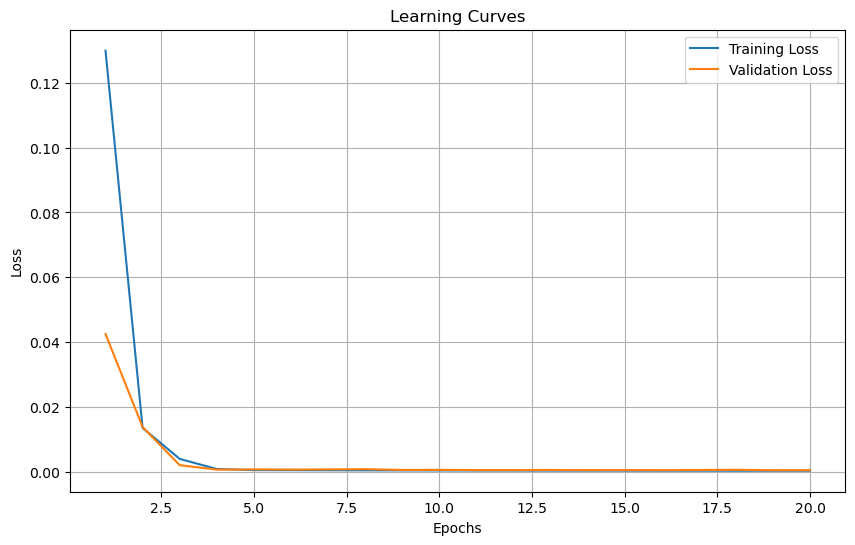

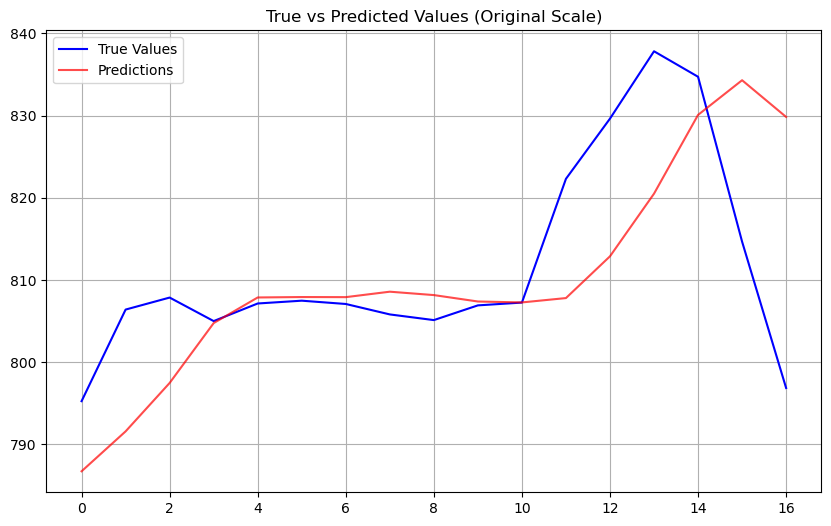

In [22]:




full_train = pd.concat([train_df, val_df], axis=0)
full_train.reset_index(drop=True, inplace=True)
train_open = full_train[['Open']]
test_open = test_df[['Open']]

print(len(train_open), len(test_open))


scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(train_open)
train_scaled_full = scaler.transform(train_open)  
test_scaled_full = scaler.transform(test_open)


X_train_full, y_train_full = prepare_sequences(data = train_scaled_full, N =objective_optimize_gru.best_hyperparams['sequence'] )
X_test_full, y_test_full = prepare_sequences(data = test_scaled_full,N =objective_optimize_gru.best_hyperparams['sequence'] )



model_retrained_gru = create_model_GRU(layers=objective_optimize_gru.best_hyperparams['layers'],
                          optimizer=objective_optimize_gru.best_hyperparams['optimizer'], 
                          sequence=objective_optimize_gru.best_hyperparams['sequence'], 
                          units=objective_optimize_gru.best_hyperparams['units'])



early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_retrained_gru.fit(
        X_train_full, y_train_full,
        epochs=20,
        batch_size=16,
        validation_data=(X_test_full, y_test_full),
        callbacks=[early_stopping],
        verbose=2
    )

loss_gru = model_retrained_gru.evaluate(X_test_full, y_test_full, verbose = 0)
print(f"Test Loss: {loss_gru}")
print(f"RMSE  {np.sqrt(loss_gru)}")
predictions = model_retrained_gru.predict(X_test_full)


plot_learning_curves(history)


plot_predictions(yhat = predictions, ytrue=y_test_full, scaler = scaler, target_column_index=0 )

## LSTM Baseline

In [23]:
train = train_df[['Open']]
test = test_df[['Open']]
val = val_df[['Open']]
N = 15
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(train)
train_scaled = scaler.transform(train)  
val_scaled = scaler.transform(val)       
X_train, y_train = prepare_sequences(train_scaled, N = 15)
X_val, y_val = prepare_sequences(val_scaled, N = 15)



In [24]:
lstm = Sequential([
    LSTM(units = 50, activation='tanh', input_shape=(N, n_features)),
    Dense(1)  
])
lstm.compile(optimizer='adam', loss='mse')
history = lstm.fit(X_train, y_train, epochs=20, batch_size=16, validation_data = (X_val,y_val))

Epoch 1/20
62/62 [==============================] - 2s 19ms/step - loss: 0.0266 - val_loss: 0.0031
Epoch 2/20
62/62 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 3/20
62/62 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 4/20
62/62 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/20
62/62 [==============================] - 1s 14ms/step - loss: 9.9265e-04 - val_loss: 0.0014
Epoch 6/20
62/62 [==============================] - 1s 14ms/step - loss: 8.9823e-04 - val_loss: 0.0012
Epoch 7/20
62/62 [==============================] - 1s 12ms/step - loss: 9.0496e-04 - val_loss: 0.0012
Epoch 8/20
62/62 [==============================] - 1s 12ms/step - loss: 8.4693e-04 - val_loss: 0.0012
Epoch 9/20
62/62 [==============================] - 1s 13ms/step - loss: 8.4821e-04 - val_loss: 0.0011
Epoch 10/20
62/62 [==============================] - 1s 14ms/step - loss: 8.1751e-04 - va

Val Loss: 0.0008642217144370079
8/8 [==============================] - 0s 10ms/step


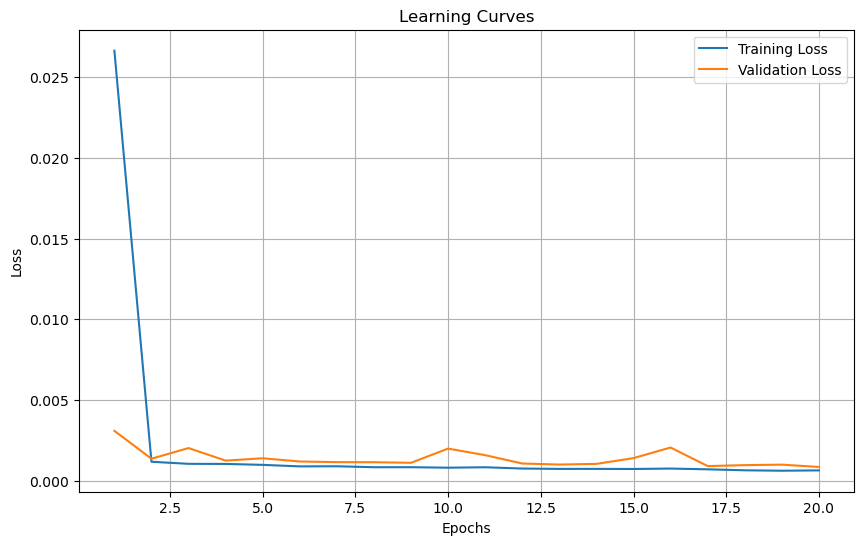

RMSE: 0.02939764811063987


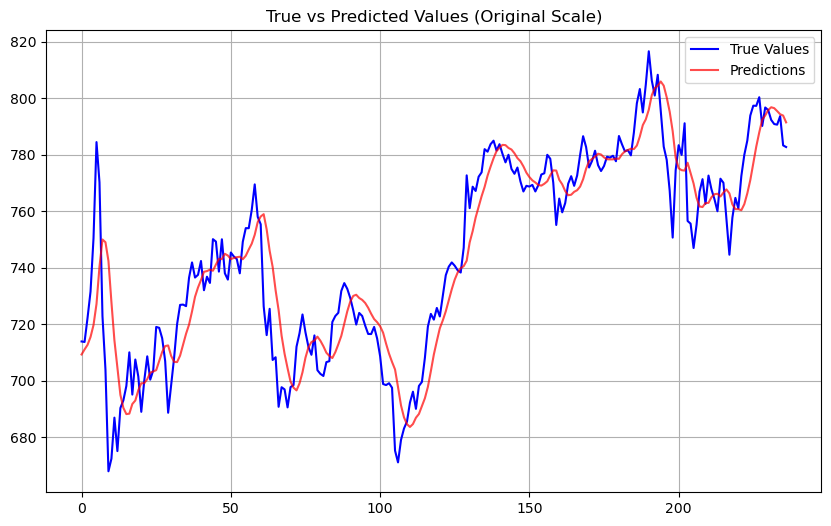

In [25]:
loss_lstm = lstm.evaluate(X_val, y_val, verbose = 0)
print(f"Val Loss: {loss_lstm}")
pred_lstm = lstm.predict(X_val)


plot_learning_curves(history)
lstm_rmse = evaluate_rmse(model=lstm, X=X_val, y = y_val)
print(f"RMSE: {lstm_rmse}")
plot_predictions(yhat = pred_lstm, ytrue=y_val, scaler = scaler, target_column_index=0 )

## LSTM Optimization

In [26]:

def create_model_LSTM(layers, optimizer, sequence, units):
    model = Sequential()
    
    for i in range(layers):
        if i == 0:
            model.add(LSTM(units, activation='tanh', return_sequences=(i < layers - 1), input_shape=(sequence, 1)))
        else:
            model.add(LSTM(units, activation='tanh', return_sequences=(i < layers - 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    
    return model





def objective_optimize_lstm(trial):
   
    layers = trial.suggest_int("layers", 1,5)  
    units = trial.suggest_int("units", 10, 100, step=10)  
    optimizer = trial.suggest_categorical("optimizer", ["adam"])  
    sequence = trial.suggest_int("sequence", 1, 10)  
    X_train, y_train = prepare_sequences(train_scaled, N=sequence)
    X_val, y_val = prepare_sequences(val_scaled, N=sequence)
    model = create_model_LSTM(layers=layers, optimizer=optimizer, sequence=sequence, units=units)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=16,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=2
    )
    val_loss = model.evaluate(X_val, y_val, verbose=0)
    val_rmse = np.sqrt(val_loss)

    if val_rmse < objective_optimize_lstm.best_rmse:
        objective_optimize_lstm.best_rmse = val_rmse
        objective_optimize_lstm.best_hyperparams = {
            "layers": layers,
            "units": units,
            "optimizer": optimizer,
            "sequence": sequence
        }
        print(f"New Best Validation RMSE: {objective_optimize_lstm.best_rmse}")
        print(f"New Best Hyperparameters: {objective_optimize_lstm.best_hyperparams}")

    return val_rmse




objective_optimize_lstm.best_rmse = lstm_rmse
objective_optimize_lstm.best_hyperparams = None
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective_optimize_lstm, n_trials=10)


print("Best Validation RMSE:", objective_optimize_lstm.best_rmse )
print("Best Hyperparameters:", objective_optimize_lstm.best_hyperparams)

[I 2024-12-01 20:29:54,677] A new study created in memory with name: no-name-07e7348a-306d-42ad-921f-5db5f1b73778


Epoch 1/10
63/63 - 4s - loss: 0.0160 - val_loss: 0.0016 - 4s/epoch - 64ms/step
Epoch 2/10
63/63 - 1s - loss: 9.0838e-04 - val_loss: 0.0018 - 1s/epoch - 19ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0010 - val_loss: 0.0013 - 1s/epoch - 23ms/step
Epoch 4/10
63/63 - 2s - loss: 0.0010 - val_loss: 0.0031 - 2s/epoch - 25ms/step
Epoch 5/10
63/63 - 1s - loss: 8.5358e-04 - val_loss: 0.0013 - 1s/epoch - 18ms/step
Epoch 6/10
63/63 - 1s - loss: 8.1144e-04 - val_loss: 0.0012 - 1s/epoch - 23ms/step
Epoch 7/10
63/63 - 1s - loss: 8.3795e-04 - val_loss: 0.0012 - 1s/epoch - 21ms/step
Epoch 8/10
63/63 - 1s - loss: 9.3445e-04 - val_loss: 0.0018 - 1s/epoch - 22ms/step
Epoch 9/10
63/63 - 1s - loss: 8.0782e-04 - val_loss: 0.0024 - 1s/epoch - 19ms/step
Epoch 10/10
63/63 - 1s - loss: 8.3681e-04 - val_loss: 0.0023 - 1s/epoch - 17ms/step


[I 2024-12-01 20:30:11,238] Trial 0 finished with value: 0.048452852108139856 and parameters: {'layers': 2, 'units': 100, 'optimizer': 'adam', 'sequence': 8}. Best is trial 0 with value: 0.048452852108139856.


Epoch 1/10
63/63 - 6s - loss: 0.1167 - val_loss: 0.0971 - 6s/epoch - 92ms/step
Epoch 2/10
63/63 - 2s - loss: 0.0256 - val_loss: 0.0173 - 2s/epoch - 29ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0040 - val_loss: 0.0173 - 1s/epoch - 23ms/step
Epoch 4/10
63/63 - 2s - loss: 0.0019 - val_loss: 0.0064 - 2s/epoch - 27ms/step
Epoch 5/10
63/63 - 2s - loss: 0.0013 - val_loss: 0.0075 - 2s/epoch - 26ms/step
Epoch 6/10
63/63 - 2s - loss: 9.9528e-04 - val_loss: 0.0022 - 2s/epoch - 28ms/step
Epoch 7/10
63/63 - 2s - loss: 7.4643e-04 - val_loss: 0.0014 - 2s/epoch - 25ms/step
Epoch 8/10
63/63 - 1s - loss: 6.0351e-04 - val_loss: 8.0197e-04 - 1s/epoch - 24ms/step
Epoch 9/10
63/63 - 1s - loss: 5.3448e-04 - val_loss: 8.3579e-04 - 1s/epoch - 24ms/step
Epoch 10/10
63/63 - 2s - loss: 4.7779e-04 - val_loss: 7.0505e-04 - 2s/epoch - 29ms/step


[I 2024-12-01 20:30:32,678] Trial 1 finished with value: 0.026552788847319892 and parameters: {'layers': 3, 'units': 20, 'optimizer': 'adam', 'sequence': 2}. Best is trial 1 with value: 0.026552788847319892.


New Best Validation RMSE: 0.026552788847319892
New Best Hyperparameters: {'layers': 3, 'units': 20, 'optimizer': 'adam', 'sequence': 2}
Epoch 1/10
63/63 - 2s - loss: 0.0226 - val_loss: 0.0022 - 2s/epoch - 38ms/step
Epoch 2/10
63/63 - 1s - loss: 8.6076e-04 - val_loss: 0.0018 - 689ms/epoch - 11ms/step
Epoch 3/10
63/63 - 1s - loss: 7.6190e-04 - val_loss: 0.0012 - 730ms/epoch - 12ms/step
Epoch 4/10
63/63 - 1s - loss: 7.6891e-04 - val_loss: 0.0012 - 674ms/epoch - 11ms/step
Epoch 5/10
63/63 - 1s - loss: 7.4101e-04 - val_loss: 0.0011 - 735ms/epoch - 12ms/step
Epoch 6/10
63/63 - 1s - loss: 7.4072e-04 - val_loss: 0.0013 - 700ms/epoch - 11ms/step
Epoch 7/10
63/63 - 1s - loss: 7.6063e-04 - val_loss: 0.0011 - 684ms/epoch - 11ms/step
Epoch 8/10
63/63 - 1s - loss: 7.1704e-04 - val_loss: 0.0011 - 750ms/epoch - 12ms/step
Epoch 9/10
63/63 - 1s - loss: 7.0638e-04 - val_loss: 0.0011 - 1s/epoch - 20ms/step
Epoch 10/10
63/63 - 1s - loss: 7.2865e-04 - val_loss: 0.0016 - 789ms/epoch - 13ms/step


[I 2024-12-01 20:30:42,558] Trial 2 finished with value: 0.039512842726171435 and parameters: {'layers': 1, 'units': 90, 'optimizer': 'adam', 'sequence': 7}. Best is trial 1 with value: 0.026552788847319892.


Epoch 1/10
63/63 - 8s - loss: 0.0927 - val_loss: 0.1544 - 8s/epoch - 132ms/step
Epoch 2/10
63/63 - 2s - loss: 0.0090 - val_loss: 0.0021 - 2s/epoch - 35ms/step
Epoch 3/10
63/63 - 3s - loss: 0.0019 - val_loss: 0.0025 - 3s/epoch - 40ms/step
Epoch 4/10
63/63 - 2s - loss: 0.0019 - val_loss: 0.0023 - 2s/epoch - 35ms/step
Epoch 5/10
63/63 - 3s - loss: 0.0018 - val_loss: 0.0042 - 3s/epoch - 46ms/step
Epoch 6/10
63/63 - 2s - loss: 0.0019 - val_loss: 0.0022 - 2s/epoch - 32ms/step
Epoch 7/10
63/63 - 2s - loss: 0.0018 - val_loss: 0.0024 - 2s/epoch - 37ms/step


[I 2024-12-01 20:31:06,083] Trial 3 finished with value: 0.04602428946906879 and parameters: {'layers': 4, 'units': 10, 'optimizer': 'adam', 'sequence': 10}. Best is trial 1 with value: 0.026552788847319892.


Epoch 1/10
63/63 - 10s - loss: 0.1091 - val_loss: 0.1942 - 10s/epoch - 153ms/step
Epoch 2/10
63/63 - 3s - loss: 0.0181 - val_loss: 0.0100 - 3s/epoch - 40ms/step
Epoch 3/10
63/63 - 3s - loss: 0.0020 - val_loss: 0.0011 - 3s/epoch - 50ms/step
Epoch 4/10
63/63 - 2s - loss: 0.0010 - val_loss: 0.0013 - 2s/epoch - 38ms/step
Epoch 5/10
63/63 - 3s - loss: 8.1737e-04 - val_loss: 0.0014 - 3s/epoch - 41ms/step
Epoch 6/10
63/63 - 2s - loss: 7.8663e-04 - val_loss: 0.0021 - 2s/epoch - 38ms/step
Epoch 7/10
63/63 - 2s - loss: 7.7115e-04 - val_loss: 0.0017 - 2s/epoch - 37ms/step
Epoch 8/10
63/63 - 3s - loss: 7.0440e-04 - val_loss: 0.0025 - 3s/epoch - 42ms/step


[I 2024-12-01 20:31:34,865] Trial 4 finished with value: 0.033527243841049735 and parameters: {'layers': 5, 'units': 30, 'optimizer': 'adam', 'sequence': 2}. Best is trial 1 with value: 0.026552788847319892.


Epoch 1/10
63/63 - 3s - loss: 0.0252 - val_loss: 0.0043 - 3s/epoch - 41ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0012 - val_loss: 0.0017 - 814ms/epoch - 13ms/step
Epoch 3/10
63/63 - 1s - loss: 7.1564e-04 - val_loss: 0.0022 - 736ms/epoch - 12ms/step
Epoch 4/10
63/63 - 1s - loss: 7.1317e-04 - val_loss: 0.0011 - 700ms/epoch - 11ms/step
Epoch 5/10
63/63 - 1s - loss: 6.8477e-04 - val_loss: 0.0015 - 791ms/epoch - 13ms/step
Epoch 6/10
63/63 - 1s - loss: 6.7111e-04 - val_loss: 0.0014 - 723ms/epoch - 11ms/step
Epoch 7/10
63/63 - 1s - loss: 6.6774e-04 - val_loss: 0.0025 - 721ms/epoch - 11ms/step
Epoch 8/10
63/63 - 1s - loss: 6.6184e-04 - val_loss: 0.0013 - 768ms/epoch - 12ms/step
Epoch 9/10
63/63 - 1s - loss: 6.6593e-04 - val_loss: 0.0011 - 753ms/epoch - 12ms/step
Epoch 10/10
63/63 - 1s - loss: 6.3160e-04 - val_loss: 0.0010 - 743ms/epoch - 12ms/step


[I 2024-12-01 20:31:44,664] Trial 5 finished with value: 0.03195149622732197 and parameters: {'layers': 1, 'units': 40, 'optimizer': 'adam', 'sequence': 6}. Best is trial 1 with value: 0.026552788847319892.


Epoch 1/10
63/63 - 6s - loss: 0.0366 - val_loss: 0.0016 - 6s/epoch - 102ms/step
Epoch 2/10
63/63 - 2s - loss: 0.0014 - val_loss: 0.0017 - 2s/epoch - 26ms/step
Epoch 3/10
63/63 - 2s - loss: 0.0011 - val_loss: 0.0015 - 2s/epoch - 27ms/step
Epoch 4/10
63/63 - 2s - loss: 0.0011 - val_loss: 0.0015 - 2s/epoch - 34ms/step
Epoch 5/10
63/63 - 2s - loss: 0.0011 - val_loss: 0.0021 - 2s/epoch - 28ms/step
Epoch 6/10
63/63 - 2s - loss: 0.0011 - val_loss: 0.0014 - 2s/epoch - 25ms/step
Epoch 7/10
63/63 - 2s - loss: 0.0011 - val_loss: 0.0014 - 2s/epoch - 31ms/step
Epoch 8/10
63/63 - 2s - loss: 0.0010 - val_loss: 0.0016 - 2s/epoch - 26ms/step
Epoch 9/10
63/63 - 2s - loss: 0.0011 - val_loss: 0.0018 - 2s/epoch - 25ms/step
Epoch 10/10
63/63 - 2s - loss: 0.0011 - val_loss: 0.0014 - 2s/epoch - 27ms/step


[I 2024-12-01 20:32:07,392] Trial 6 finished with value: 0.038012003356378526 and parameters: {'layers': 3, 'units': 30, 'optimizer': 'adam', 'sequence': 7}. Best is trial 1 with value: 0.026552788847319892.


Epoch 1/10
63/63 - 3s - loss: 0.0707 - val_loss: 0.0232 - 3s/epoch - 49ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0066 - val_loss: 0.0031 - 720ms/epoch - 11ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0013 - val_loss: 0.0016 - 698ms/epoch - 11ms/step
Epoch 4/10
63/63 - 1s - loss: 6.9311e-04 - val_loss: 0.0027 - 1s/epoch - 17ms/step
Epoch 5/10
63/63 - 1s - loss: 6.7550e-04 - val_loss: 0.0021 - 699ms/epoch - 11ms/step
Epoch 6/10
63/63 - 1s - loss: 6.7323e-04 - val_loss: 0.0013 - 872ms/epoch - 14ms/step
Epoch 7/10
63/63 - 1s - loss: 6.2335e-04 - val_loss: 0.0017 - 737ms/epoch - 12ms/step
Epoch 8/10
63/63 - 1s - loss: 6.0154e-04 - val_loss: 0.0010 - 727ms/epoch - 12ms/step
Epoch 9/10
63/63 - 1s - loss: 5.9836e-04 - val_loss: 0.0010 - 685ms/epoch - 11ms/step
Epoch 10/10
63/63 - 1s - loss: 5.6942e-04 - val_loss: 0.0011 - 740ms/epoch - 12ms/step


[I 2024-12-01 20:32:17,848] Trial 7 finished with value: 0.03312826482972537 and parameters: {'layers': 1, 'units': 30, 'optimizer': 'adam', 'sequence': 4}. Best is trial 1 with value: 0.026552788847319892.


Epoch 1/10
63/63 - 6s - loss: 0.0570 - val_loss: 0.0027 - 6s/epoch - 99ms/step
Epoch 2/10
63/63 - 2s - loss: 0.0013 - val_loss: 0.0026 - 2s/epoch - 33ms/step
Epoch 3/10
63/63 - 2s - loss: 6.4667e-04 - val_loss: 0.0026 - 2s/epoch - 25ms/step
Epoch 4/10
63/63 - 2s - loss: 5.1653e-04 - val_loss: 7.6327e-04 - 2s/epoch - 26ms/step
Epoch 5/10
63/63 - 2s - loss: 4.4492e-04 - val_loss: 0.0014 - 2s/epoch - 29ms/step
Epoch 6/10
63/63 - 2s - loss: 4.5899e-04 - val_loss: 7.0587e-04 - 2s/epoch - 26ms/step
Epoch 7/10
63/63 - 2s - loss: 4.2615e-04 - val_loss: 6.5179e-04 - 2s/epoch - 37ms/step
Epoch 8/10
63/63 - 2s - loss: 4.3254e-04 - val_loss: 7.5742e-04 - 2s/epoch - 26ms/step
Epoch 9/10
63/63 - 2s - loss: 4.1080e-04 - val_loss: 7.6044e-04 - 2s/epoch - 28ms/step
Epoch 10/10
63/63 - 1s - loss: 4.4258e-04 - val_loss: 6.9346e-04 - 1s/epoch - 23ms/step


[I 2024-12-01 20:32:40,854] Trial 8 finished with value: 0.02633359654640427 and parameters: {'layers': 3, 'units': 80, 'optimizer': 'adam', 'sequence': 2}. Best is trial 8 with value: 0.02633359654640427.


New Best Validation RMSE: 0.02633359654640427
New Best Hyperparameters: {'layers': 3, 'units': 80, 'optimizer': 'adam', 'sequence': 2}
Epoch 1/10
63/63 - 6s - loss: 0.0988 - val_loss: 0.1008 - 6s/epoch - 94ms/step
Epoch 2/10
63/63 - 1s - loss: 0.0124 - val_loss: 0.0032 - 1s/epoch - 22ms/step
Epoch 3/10
63/63 - 1s - loss: 0.0014 - val_loss: 0.0120 - 1s/epoch - 21ms/step
Epoch 4/10
63/63 - 2s - loss: 0.0011 - val_loss: 0.0065 - 2s/epoch - 27ms/step
Epoch 5/10
63/63 - 2s - loss: 7.5979e-04 - val_loss: 0.0021 - 2s/epoch - 29ms/step
Epoch 6/10
63/63 - 1s - loss: 5.5916e-04 - val_loss: 0.0024 - 1s/epoch - 22ms/step
Epoch 7/10
63/63 - 2s - loss: 4.2483e-04 - val_loss: 0.0011 - 2s/epoch - 25ms/step
Epoch 8/10
63/63 - 2s - loss: 3.4845e-04 - val_loss: 8.8358e-04 - 2s/epoch - 25ms/step
Epoch 9/10
63/63 - 1s - loss: 3.0867e-04 - val_loss: 4.9859e-04 - 1s/epoch - 23ms/step
Epoch 10/10
63/63 - 1s - loss: 2.9955e-04 - val_loss: 4.0130e-04 - 1s/epoch - 23ms/step


[I 2024-12-01 20:33:01,225] Trial 9 finished with value: 0.020032566612501003 and parameters: {'layers': 3, 'units': 60, 'optimizer': 'adam', 'sequence': 1}. Best is trial 9 with value: 0.020032566612501003.


New Best Validation RMSE: 0.020032566612501003
New Best Hyperparameters: {'layers': 3, 'units': 60, 'optimizer': 'adam', 'sequence': 1}
Best Validation RMSE: 0.020032566612501003
Best Hyperparameters: {'layers': 3, 'units': 60, 'optimizer': 'adam', 'sequence': 1}


## Retraining Optimized LSTM

1258 20
Epoch 1/20
79/79 - 4s - loss: 0.0132 - val_loss: 5.3690e-04 - 4s/epoch - 57ms/step
Epoch 2/20
79/79 - 2s - loss: 2.8119e-04 - val_loss: 3.8561e-04 - 2s/epoch - 30ms/step
Epoch 3/20
79/79 - 2s - loss: 3.0165e-04 - val_loss: 5.4047e-04 - 2s/epoch - 21ms/step
Epoch 4/20
79/79 - 2s - loss: 2.8962e-04 - val_loss: 3.7833e-04 - 2s/epoch - 21ms/step
Epoch 5/20
79/79 - 2s - loss: 2.9692e-04 - val_loss: 3.9451e-04 - 2s/epoch - 23ms/step
Epoch 6/20
79/79 - 2s - loss: 2.8234e-04 - val_loss: 2.3655e-04 - 2s/epoch - 20ms/step
Epoch 7/20
79/79 - 2s - loss: 3.3567e-04 - val_loss: 8.3212e-04 - 2s/epoch - 22ms/step
Epoch 8/20
79/79 - 2s - loss: 3.4736e-04 - val_loss: 4.6327e-04 - 2s/epoch - 21ms/step
Epoch 9/20
79/79 - 2s - loss: 3.0557e-04 - val_loss: 7.7385e-04 - 2s/epoch - 20ms/step
Epoch 10/20
79/79 - 2s - loss: 3.0243e-04 - val_loss: 0.0012 - 2s/epoch - 23ms/step
Epoch 11/20
79/79 - 2s - loss: 3.0224e-04 - val_loss: 0.0013 - 2s/epoch - 20ms/step
1/1 [==============================] - 0s 112

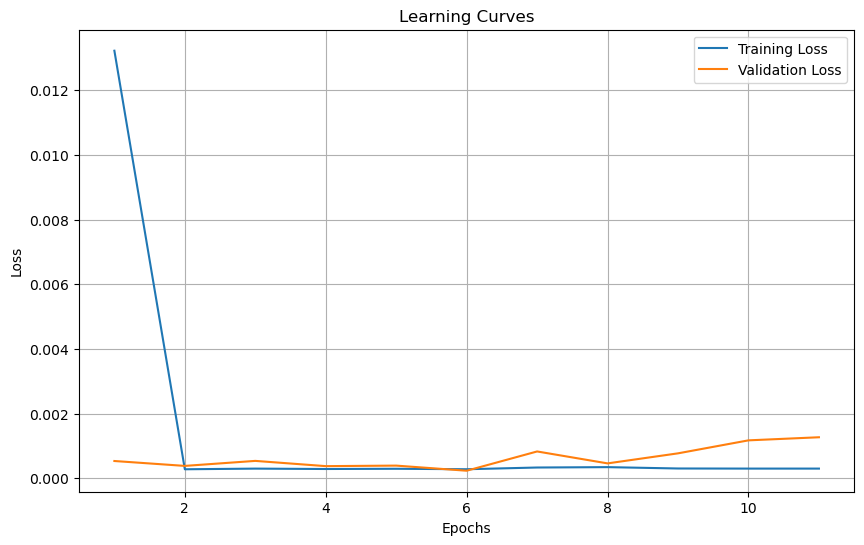

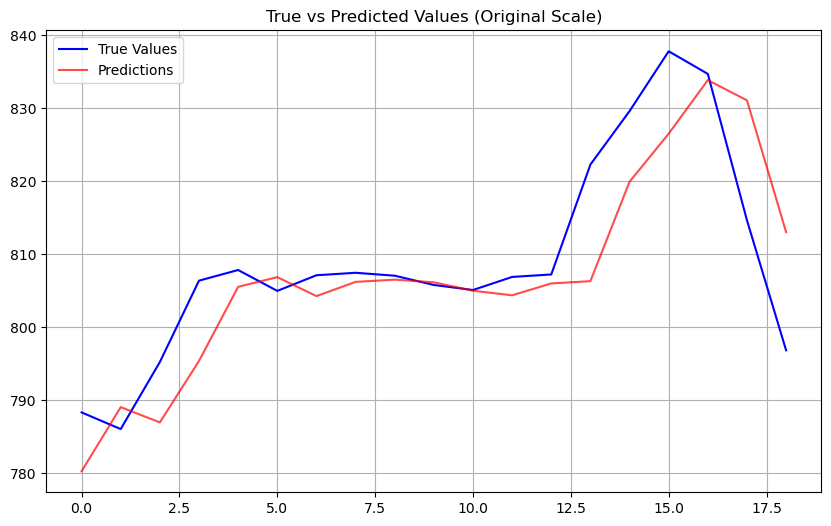

In [27]:




full_train = pd.concat([train_df, val_df], axis=0)
full_train.reset_index(drop=True, inplace=True)
train_open = full_train[['Open']]
test_open = test_df[['Open']]

print(len(train_open), len(test_open))

scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(train_open)
train_scaled_full = scaler.transform(train_open)  
test_scaled_full = scaler.transform(test_open)


X_train_full, y_train_full = prepare_sequences(data = train_scaled_full, N =objective_optimize_lstm.best_hyperparams['sequence'] )
X_test_full, y_test_full = prepare_sequences(data = test_scaled_full,N =objective_optimize_lstm.best_hyperparams['sequence'] )




model_retrained_lstm = create_model_RNN(layers=objective_optimize_lstm.best_hyperparams['layers'],
                          optimizer=objective_optimize_lstm.best_hyperparams['optimizer'], 
                          sequence=objective_optimize_lstm.best_hyperparams['sequence'], 
                          units=objective_optimize_lstm.best_hyperparams['units'])



early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_retrained_lstm.fit(
        X_train_full, y_train_full,
        epochs=20,
        batch_size=16,
        validation_data=(X_test_full, y_test_full),
        callbacks=[early_stopping],
        verbose=2
    )

loss_vnn = model_retrained_lstm.evaluate(X_test_full, y_test_full)
print(f"Test Loss: {loss_vnn}")
print(f"Test RMSE: {np.sqrt(loss_vnn)}")
predictions = model_retrained_lstm.predict(X_test_full)


plot_learning_curves(history)


plot_predictions(yhat = predictions, ytrue=y_test_full, scaler = scaler, target_column_index=0 )